# Percobaan Menggunakan Ekualisasi Histogram dan Deteksi Tepi Sobel

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Kode di atas bertujuan untuk mengimpor berbagai library yang dibutuhkan untuk menjalankan proses pengolahan citra dan klasifikasi data. Modul `os` berfungsi untuk menjelajahi direktori dan membaca file yang tersimpan. Library `cv2` atau OpenCV digunakan dalam proses pembacaan dan manipulasi gambar. Library  `matplotlib.pyplot` berfungsi untuk menampilkan gambar serta membuat berbagai jenis grafik. lalu library `numpy` untuk pengolahan data numerik dan array, sedangkan `pandas` dipakai untuk mengelola data dalam format tabel atau dataframe.

Fungsi `train_test_split` dan `cross_val_predict` digunakan dalam pembagian data menjadi data latih dan data uji, serta untuk melakukan validasi silang. Fungsi `accuracy_score`, `precision_score`, `recall_score`, `f1_score`, `classification_report`, `confusion_matrix`, dan `ConfusionMatrixDisplay` berfungis  Untuk mengevaluasi performa model klasifikasi, digunakan beberapa metrik seperti .

Ekstraksi fitur tekstur dari gambar dilakukan dengan menggunakan `graycomatrix` dan `graycoprops`, yang merupakan bagian dari metode GLCM (Gray Level Co-occurrence Matrix). Selain itu, fungsi `entropy` digunakan untuk menghitung nilai entropi dari fitur tekstur.

Dalam hal klasifikasi, digunakan tiga algoritma utama, yaitu `RandomForestClassifier`, `SVC` (Support Vector Classifier), dan `KNeighborsClassifier`. library `seaborn` berfungsi untuk mendukung visualisasi data seperti heatmap atau grafik lainnya, d.

# Data Loading

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    if sub_folder[0] == ".":
        continue

    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)

        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

Kode di atas digunakan untuk membaca seluruh gambar dalam folder `dataset`, yang di dalamnya terdiri dari beberapa subfolder. Setiap subfolder dianggap sebagai representasi dari satu kelas atau kategori gambar. Pertama, disiapkan tiga list kosong yaitu `data`, `labels`, dan `file_name` untuk menyimpan gambar grayscale, label kelas berdasarkan nama subfolder, serta nama file asli dari gambar. Program kemudian melakukan iterasi ke seluruh subfolder. Jika ada folder yang diawali dengan titik (biasanya folder sistem tersembunyi), maka akan dilewati agar tidak ikut diproses. Setiap gambar di dalam subfolder akan dibaca menggunakan OpenCV dalam mode grayscale. Hasil pembacaan gambar disimpan ke `data`, nama subfolder yang menjadi label dimasukkan ke `labels`, dan nama filenya disimpan ke `file_name`. Setelah semua gambar terbaca, list `data` dan `labels` dikonversi menjadi array NumPy. Ini bertujuan agar data lebih efisien untuk diproses lebih lanjut, seperti saat melakukan ekstraksi fitur atau klasifikasi.


# Data Preparation

## Define Preprocessing Function

In [ ]:
def resize(image, target_size):
    result = np.zeros(target_size, image.dtype)
    step = (image.shape[0] // target_size[0], image.shape[1] // target_size[1])
    result = image[0::step[0], 0::step[1]]
    return result

Kode di atas merupakan fungsi untuk mengubah ukuran (resize) citra secara manual ke dimensi yang diinginkan. Awalnya, fungsi ini membuat array kosong bernama `result` dengan ukuran `target_size` dan tipe data yang sama dengan gambar asli. Kemudian, langkah atau jarak antar piksel yang akan diambil dari citra asli dihitung melalui pembagian ukuran asli dengan ukuran target. Selanjutnya, citra hasil resize diambil menggunakan teknik slicing berdasarkan langkah tersebut, yaitu memilih piksel secara berkala dari gambar asli. Hasil akhirnya adalah citra baru yang ukurannya telah diperkecil atau diperbesar sesuai kebutuhan.

In [ ]:
def prepro1(img):
    result = np.zeros(img.shape, dtype=img.dtype)

    eqs: np.array = np.zeros(256, np.uint8)

    hist: np.array = np.zeros(256, np.int32)
    for c in img.ravel():
        hist[int(c)] += 1

    cdf: np.array = np.zeros(256, float)

    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = hist[i] + cdf[i - 1]

    eqs = np.round(cdf / cdf[-1] * 255).astype(np.uint8)
    
    result = eqs[img]

    return result

Kode di atas merupakan fungsi bernama `prepro1` yang digunakan untuk melakukan ekualisasi histogram pada citra grayscale. Awalnya, fungsi ini membuat array `result` dengan ukuran dan tipe data yang sama dengan citra input. Kemudian, histogram citra dihitung dengan cara menelusuri setiap piksel dan mencatat frekuensinya dalam array `hist`.

Setelah itu, fungsi menghitung *cumulative distribution function* (CDF) dari histogram, yang disimpan dalam array `cdf`. Nilai CDF ini kemudian dinormalisasi dan dikalikan dengan 255 untuk menghasilkan transformasi histogram yang merata, disimpan dalam array `eqs`.

Terakhir, nilai piksel dari gambar asli diganti menggunakan nilai yang telah ditransformasikan melalui array `eqs`, dan hasil akhirnya dikembalikan dalam variabel `result`. Fungsi ini bertujuan untuk meningkatkan kontras citra, terutama pada gambar dengan rentang intensitas yang sempit.


In [ ]:
# Deteksi Tepi - Metode Sobel
def prepro4(img):
    kernel = np.array([
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ],
        [
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=img.dtype)
    padded[2:, 2:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

Kode di atas merupakan fungsi `prepro4(img)` yang digunakan untuk melakukan deteksi tepi pada gambar menggunakan metode Sobel. Pada fungsi ini, dua buah kernel disiapkan dalam variabel `kernel` untuk mendeteksi perubahan intensitas piksel secara horizontal dan vertikal. Gambar asli diberi padding terlebih dahulu menggunakan variabel `padded`, agar proses konvolusi tidak keluar dari batas gambar.

Selanjutnya, dilakukan perulangan pada setiap piksel dalam gambar menggunakan indeks `y` dan `x`. Untuk setiap posisi piksel, dihitung nilai gradien horizontal (`sx`) dan vertikal (`sy`) dengan mengalikan potongan gambar dengan masing-masing kernel dan menjumlahkannya. Nilai tepi pada posisi tersebut dihitung dengan rumus √(sx² + sy²), lalu disimpan ke dalam variabel `result`.

## Preprocessing

In [4]:
dataPreprocessed = []
for i in range(len(data)):
    img = prepro1(data[i])
    img = prepro4(img)
    dataPreprocessed.append(img)

Kode di atas merupakan proses preproses citra yang dilakukan terhadap seluruh data gambar dalam list `data`. Awalnya, setiap gambar diproses menggunakan fungsi `prepro1()` untuk melakukan ekualisasi histogram guna meningkatkan kontras. Setelah itu, gambar yang telah diperbaiki kontrasnya diproses kembali menggunakan fungsi `prepro4()`, yaitu deteksi tepi dengan metode Sobel untuk menyoroti garis tepi objek. Hasil akhir dari kedua tahapan ini kemudian disimpan dalam list `dataPreprocessed` dan siap digunakan untuk tahap ekstraksi fitur atau pelatihan model klasifikasi.

Kode di bawah ini digunakan untuk menampilkan hasil visualisasi dari gambar-gambar yang telah dipra-proses, dikelompokkan berdasarkan labelnya.

Variabel `step` menentukan jumlah gambar yang dimiliki oleh setiap label, dalam hal ini sebanyak 100 gambar per kelas.

Perulangan dilakukan untuk setiap label. Untuk setiap iterasi, judul plot diatur berdasarkan label yang sedang diproses. Lalu, ditampilkan 20 gambar pertama dari label tersebut menggunakan subplot dengan ukuran 4 baris dan 5 kolom.

Setiap gambar ditampilkan dalam mode grayscale dan tanpa sumbu (axis), agar tampilan lebih bersih. Setelah semua subplot terisi, `plt.tight_layout()` dipanggil untuk menghindari tumpang tindih antar gambar, dan `plt.show()` digunakan untuk menampilkan hasilnya.

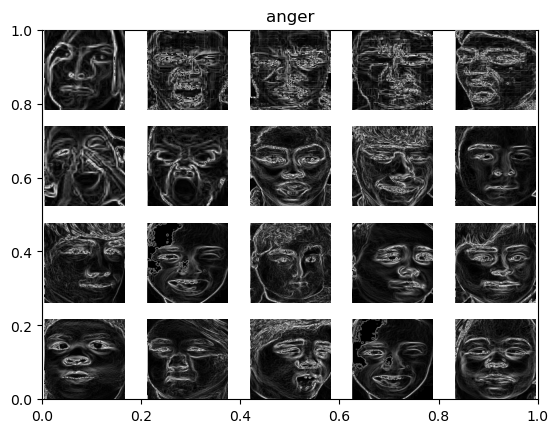

<Figure size 2000x2000 with 0 Axes>

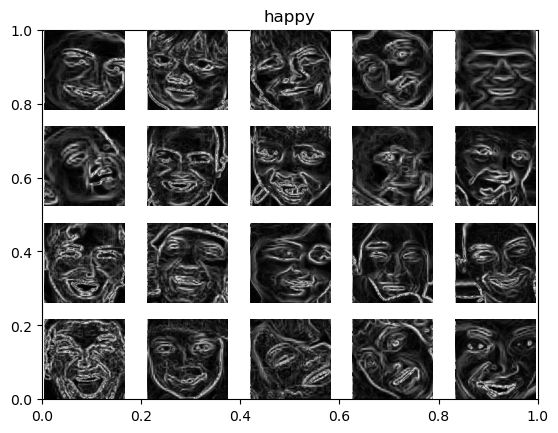

<Figure size 2000x2000 with 0 Axes>

In [5]:
step = 100 # Jumlah Gambar Per Label
for i in range(len(dataPreprocessed) // step):
    plt.title(labels[i * step])
    for j in range(0, 20):
        plt.subplot(4, 5, j + 1)
        plt.imshow(dataPreprocessed[(i * step) + j], cmap="gray")
        plt.axis(False)

    plt.figure(figsize=(20, 20))
    plt.tight_layout()
    plt.show()

## Feature Extraction

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode di atas adalah fungsi bernama `glcm` yang digunakan untuk membuat matriks GLCM (Gray Level Co-occurrence Matrix) dari sebuah citra. Fungsi ini menerima dua parameter: `image` sebagai input citra dan `derajat` yang menentukan sudut arah matriks (hanya menerima nilai 0, 45, 90, atau 135 derajat). Berdasarkan nilai `derajat`, fungsi akan memilih sudut dalam radian yang sesuai. Setelah itu, fungsi memanggil `graycomatrix` dari pustaka skimage untuk membuat matriks GLCM dengan jarak 1 dan sudut yang telah ditentukan, menggunakan 256 level abu-abu, serta dengan opsi simetris dan normalisasi. Akhirnya, fungsi mengembalikan matriks GLCM yang telah dibuat.


In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Kode di atas merupakan fungsi `correlation(matriks)` yang berperan untuk menghitung nilai korelasi tekstur dari suatu matriks GLCM (Gray Level Co-occurrence Matrix) yang sudah terbentuk dari citra grayscale. Fungsi ini menggunakan fungsi `graycoprops` dari pustaka `skimage.feature`, yang secara khusus mengambil properti statistik dengan nama `'correlation'`, yaitu ukuran seberapa piksel dalam gambar berhubungan secara linier berdasarkan nilai keabuan. Nilai korelasi dihitung dari distribusi pasangan piksel berdasarkan arah dan jarak tertentu, dan hasilnya diakses pada indeks `[0, 0]` karena GLCM biasanya hanya memiliki satu pasangan arah dan jarak pada implementasi umum. Fungsi ini penting dalam analisis tekstur karena korelasi dapat membedakan pola-pola keteraturan dalam permukaan gambar.


In [8]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Kode di atas merupakan fungsi `dissimilarity(matriks)` yang digunakan untuk menghitung nilai ketidaksamaan tekstur dari matriks GLCM (Gray Level Co-occurrence Matrix). Nilai ini diperoleh dengan memanggil fungsi `graycoprops` dari pustaka `skimage.feature`, lalu mengambil properti `'dissimilarity'`, yang merepresentasikan seberapa besar perbedaan nilai keabuan antar pasangan piksel dalam gambar. Hasilnya diambil dari indeks `[0, 0]` karena umumnya hanya satu kombinasi jarak dan sudut yang digunakan. Fungsi ini sangat bermanfaat untuk membedakan tingkat kontras halus dalam analisis tekstur citra digital.


In [9]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Kode di atas merupakan fungsi `homogenity(matriks)` yang digunakan untuk menghitung nilai homogenitas dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix).** Fungsi ini memanfaatkan metode `graycoprops` dari pustaka `skimage.feature`, dengan parameter `'homogeneity'` yang berfungsi untuk menilai sejauh mana intensitas piksel dalam citra yang saling berdekatan memiliki kemiripan. Nilai homogenitas yang tinggi menunjukkan bahwa gambar memiliki tekstur yang seragam atau halus. Output dari fungsi ini diakses melalui indeks `[0, 0]` karena biasanya hanya satu arah dan satu jarak yang dihitung dalam GLCM. Nilai ini sering digunakan dalam ekstraksi fitur untuk analisis citra berbasis tekstur.


In [10]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Kode di atas merupakan fungsi `contrast(matriks)` yang berfungsi untuk menghitung nilai kontras dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'contrast'`, yang mengukur tingkat perbedaan intensitas antara piksel yang berdekatan pada citra. Nilai kontras yang tinggi menunjukkan adanya variasi tekstur yang besar, seperti tepi atau pola yang mencolok pada gambar. Fungsi ini mengembalikan hasil perhitungan pada indeks `[0, 0]` karena biasanya GLCM dihitung pada satu arah dan jarak tertentu. Nilai kontras ini penting dalam analisis tekstur untuk pengenalan pola atau klasifikasi citra.


In [11]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Kode di atas merupakan fungsi `ASM(matriks)` yang berfungsi untuk menghitung nilai Angular Second Moment (ASM) dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini memanfaatkan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'ASM'`, yang mengukur tingkat homogenitas atau keseragaman tekstur pada citra. Nilai ASM yang tinggi menunjukkan tekstur yang lebih seragam dan konsisten. Fungsi ini mengembalikan nilai hasil perhitungan pada indeks `[0, 0]` karena biasanya GLCM dihitung untuk satu arah dan jarak tertentu. ASM sering dipakai dalam analisis tekstur untuk mendeteksi pola dan karakteristik visual pada gambar.


In [12]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Kode di atas merupakan fungsi `energy(matriks)` yang berfungsi untuk menghitung nilai energi dari sebuah matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan metode `graycoprops` dari pustaka `skimage.feature` dengan parameter `'energy'`, yang mengukur kekuatan atau intensitas tekstur pada citra. Nilai energi menunjukkan seberapa konsisten dan berulang pola dalam tekstur gambar; semakin tinggi nilai energi, semakin homogen teksturnya. Fungsi ini mengembalikan nilai energi pada indeks `[0, 0]`, karena biasanya GLCM dihitung pada satu arah dan jarak tertentu. Energi merupakan salah satu fitur penting dalam analisis tekstur untuk pengenalan pola dan klasifikasi citra.

In [13]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode di atas merupakan fungsi `entropyGlcm(matriks)` yang berfungsi untuk menghitung entropi dari matriks GLCM (Gray Level Co-occurrence Matrix). Fungsi ini menggunakan `entropy` dari pustaka `scipy.stats`, dengan input berupa matriks yang sudah diratakan menjadi vektor satu dimensi menggunakan `matriks.ravel()`. Entropi mengukur tingkat ketidakpastian atau kompleksitas dalam tekstur citra; semakin tinggi nilai entropi, semakin kompleks dan acak pola teksturnya. Fungsi ini mengembalikan nilai entropi yang merupakan indikator penting dalam analisis tekstur untuk membedakan karakteristik permukaan dalam pengolahan citra.


In [14]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di atas menghitung matriks GLCM dari setiap gambar dalam `dataPreprocessed` untuk empat sudut yang berbeda: 0, 45, 90, dan 135 derajat. Pada setiap iterasi, fungsi `glcm` dipanggil untuk menghasilkan matriks GLCM pada sudut tertentu, lalu hasilnya disimpan ke dalam list yang sesuai. Dengan cara ini, setiap citra memiliki empat matriks GLCM yang mewakili tekstur dari berbagai arah, sehingga data tekstur menjadi lebih lengkap untuk proses analisis berikutnya.

In [15]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode di atas mendefinisikan beberapa list kosong yang nantinya akan digunakan untuk menyimpan nilai fitur tekstur dari matriks GLCM pada masing-masing sudut 0, 45, 90, dan 135 derajat. Fitur-fitur tersebut meliputi kontras, dissimilarity, homogenitas, entropi, ASM, energi, dan korelasi. Setiap list akan menampung nilai fitur yang dihitung dari setiap gambar pada sudut yang spesifik, sehingga memudahkan pengelolaan dan analisis data tekstur secara terpisah berdasarkan arah sudutnya.

In [16]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode di atas melakukan iterasi sebanyak jumlah data hasil preprocessing. Pada setiap iterasi, fungsi `correlation` dipanggil untuk menghitung nilai korelasi dari matriks GLCM pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Hasil korelasi tersebut kemudian dimasukkan ke dalam list yang sesuai (`correlation0`, `correlation45`, `correlation90`, dan `correlation135`). Proses ini menyimpan fitur korelasi tekstur dari setiap gambar untuk setiap sudut, sehingga siap digunakan untuk analisis atau klasifikasi berikutnya.

In [17]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di atas melakukan perulangan sebanyak jumlah data gambar yang diproses. Pada setiap langkah, fungsi `contrast` dipanggil untuk menghitung nilai kontras dari matriks GLCM pada empat sudut yaitu 0°, 45°, 90°, dan 135°. Nilai kontras yang didapat dari tiap sudut tersebut kemudian ditambahkan ke dalam list yang sesuai (`Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`). Dengan demikian, kode ini mengekstrak fitur tekstur kontras dari seluruh gambar pada berbagai sudut orientasi, untuk keperluan analisis lebih lanjut.

In [18]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di atas melakukan perulangan sebanyak jumlah data gambar yang diproses. Pada setiap iterasi, fungsi `dissimilarity` dipanggil untuk menghitung nilai ketidaksamaan (dissimilarity) dari matriks GLCM pada empat sudut orientasi, yaitu 0°, 45°, 90°, dan 135°. Nilai dissimilarity yang diperoleh dari masing-masing sudut tersebut kemudian disimpan ke dalam list yang sesuai (`dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`). Dengan demikian, kode ini berfungsi untuk mengekstrak fitur tekstur dissimilarity dari seluruh gambar berdasarkan berbagai sudut orientasi guna keperluan analisis lebih lanjut.


In [19]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Kode di atas melakukan perulangan sebanyak jumlah data gambar yang diproses. Pada setiap iterasi, fungsi `homogenity` dipanggil untuk menghitung nilai homogenitas dari matriks GLCM pada empat sudut orientasi, yaitu 0°, 45°, 90°, dan 135°. Nilai homogenitas yang diperoleh dari masing-masing sudut tersebut kemudian disimpan ke dalam list yang sesuai (`homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`). Dengan demikian, kode ini mengekstrak fitur tekstur homogenitas dari seluruh gambar berdasarkan berbagai sudut orientasi untuk analisis lebih lanjut.


In [20]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode di atas melakukan perulangan sebanyak jumlah data gambar yang telah diproses. Pada setiap iterasi, fungsi `entropyGlcm` digunakan untuk menghitung nilai entropi dari matriks GLCM pada empat sudut orientasi, yaitu 0°, 45°, 90°, dan 135°. Nilai entropi yang dihasilkan kemudian dimasukkan ke dalam list yang sesuai (`entropy0`, `entropy45`, `entropy90`, dan `entropy135`). Dengan demikian, kode ini mengekstrak fitur tekstur entropi dari seluruh gambar pada berbagai sudut orientasi sebagai bagian dari proses analisis tekstur.


In [21]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di atas menjalankan perulangan sebanyak jumlah data gambar yang ada. Pada setiap langkah, fungsi `ASM` dipanggil untuk menghitung nilai Angular Second Moment (ASM) dari matriks GLCM pada empat sudut orientasi, yaitu 0°, 45°, 90°, dan 135°. Nilai ASM yang diperoleh kemudian disimpan ke dalam list yang sesuai (`ASM0`, `ASM45`, `ASM90`, dan `ASM135`). Dengan demikian, kode ini mengekstrak fitur tekstur ASM dari semua gambar pada berbagai sudut untuk analisis lebih lanjut.


In [22]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di atas melakukan perulangan sebanyak jumlah data gambar yang tersedia. Pada setiap iterasi, fungsi `energy` dipanggil untuk menghitung nilai energi (energy) dari matriks GLCM pada empat sudut orientasi yaitu 0°, 45°, 90°, dan 135°. Nilai energi yang didapatkan kemudian dimasukkan ke dalam list masing-masing (`energy0`, `energy45`, `energy90`, dan `energy135`). Dengan demikian, kode ini mengekstrak fitur tekstur energi dari semua gambar pada berbagai sudut orientasi untuk digunakan dalam analisis lebih lanjut.


## Write the extraction's results to CSV

Kode di bawah membuat sebuah dictionary bernama `dataTable` yang berisi kumpulan data fitur tekstur hasil ekstraksi dari gambar, lengkap dengan nama file (`file_name`) dan label (`labels`). Setiap fitur seperti kontras, homogenitas, dissimilarity, entropi, ASM, energi, dan korelasi disimpan dalam list terpisah berdasarkan empat sudut orientasi (0°, 45°, 90°, dan 135°).

Kemudian, dictionary ini dikonversi menjadi sebuah DataFrame pandas (`df`) yang memudahkan pengelolaan data dalam bentuk tabel. Setelah itu, DataFrame disimpan ke file CSV dengan nama `hasil_ekstraksi_1.csv` tanpa menyimpan indeks baris. Terakhir, file CSV yang baru saja dibuat dibaca kembali menggunakan `pd.read_csv()` dan hasilnya ditampilkan sebagai output `hasilEkstrak`.

Dengan cara ini, data hasil ekstraksi fitur tekstur tersimpan secara rapi dan siap untuk analisis atau pengolahan lebih lanjut.


In [23]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,anger002.png,anger,525.597153,744.956605,342.174568,720.075208,0.200121,0.148213,0.227384,0.155740,...,0.001095,0.000691,0.031326,0.025872,0.033085,0.026290,0.878452,0.825915,0.920705,0.831754
1,anger003.png,anger,1804.991472,4454.555169,3320.011071,4409.263307,0.208696,0.099159,0.247244,0.101420,...,0.002622,0.001001,0.071167,0.031467,0.051206,0.031639,0.739123,0.354757,0.523162,0.361309
2,anger004.png,anger,1761.921445,3295.758712,2284.501221,3314.952241,0.145381,0.085506,0.245811,0.082481,...,0.001113,0.000355,0.033233,0.018975,0.033361,0.018846,0.717611,0.469698,0.636168,0.466613
3,anger006.png,anger,1558.837064,2853.538438,1994.258528,2888.570170,0.181470,0.101235,0.264091,0.101947,...,0.001805,0.000595,0.043923,0.024453,0.042486,0.024384,0.728121,0.501675,0.653278,0.495554
4,anger007.png,anger,1563.200713,2672.572362,2191.272021,2667.823443,0.166505,0.081141,0.112603,0.085734,...,0.000502,0.000355,0.027703,0.018301,0.022397,0.018852,0.743314,0.561138,0.647406,0.561939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,happy228.png,happy,306.317885,816.539383,592.862448,805.949164,0.259787,0.171449,0.226992,0.181028,...,0.002120,0.001547,0.048346,0.039239,0.046041,0.039333,0.924129,0.795355,0.854705,0.798030
196,happy238.png,happy,297.426890,801.285588,606.755105,791.766293,0.214896,0.119934,0.146711,0.115025,...,0.000486,0.000351,0.027582,0.019117,0.022044,0.018737,0.924025,0.793309,0.845559,0.795798
197,happy251.png,happy,238.941264,480.882101,305.090367,441.192564,0.196807,0.140435,0.205095,0.148639,...,0.000878,0.000582,0.028964,0.023740,0.029624,0.024134,0.925368,0.847409,0.904495,0.860002
198,happy262.png,happy,177.140855,473.441231,344.238649,483.748296,0.226234,0.166848,0.236443,0.159608,...,0.001074,0.000683,0.031880,0.026736,0.032765,0.026125,0.947380,0.857585,0.897447,0.854487


## Features Selection

Kode di bawah ini melakukan pemilihan fitur dari dataset dengan cara menghitung korelasi antar fitur numerik (kecuali kolom Label dan Filename). Pertama, kode menghitung matriks korelasi dari fitur-fitur tersebut. Kemudian, kode menyaring fitur yang memiliki korelasi sangat tinggi (lebih dari atau sama dengan threshold 0.95) dengan fitur lain, supaya fitur yang sangat mirip tidak ikut dipakai berbarengan. Proses ini menggunakan array boolean `columns` untuk menandai fitur yang akan dipilih. Jika dua fitur sangat berkorelasi, fitur kedua akan diabaikan agar tidak ada fitur yang duplikat. Setelah fitur yang dipilih disimpan di `x_new`, label asli tetap disimpan di variabel `y`. Terakhir, kode membuat heatmap korelasi dari fitur-fitur terpilih agar mudah divisualisasikan. Proses ini membantu mengurangi redundansi data dan memperbaiki kualitas fitur untuk analisis lebih lanjut.


<Axes: >

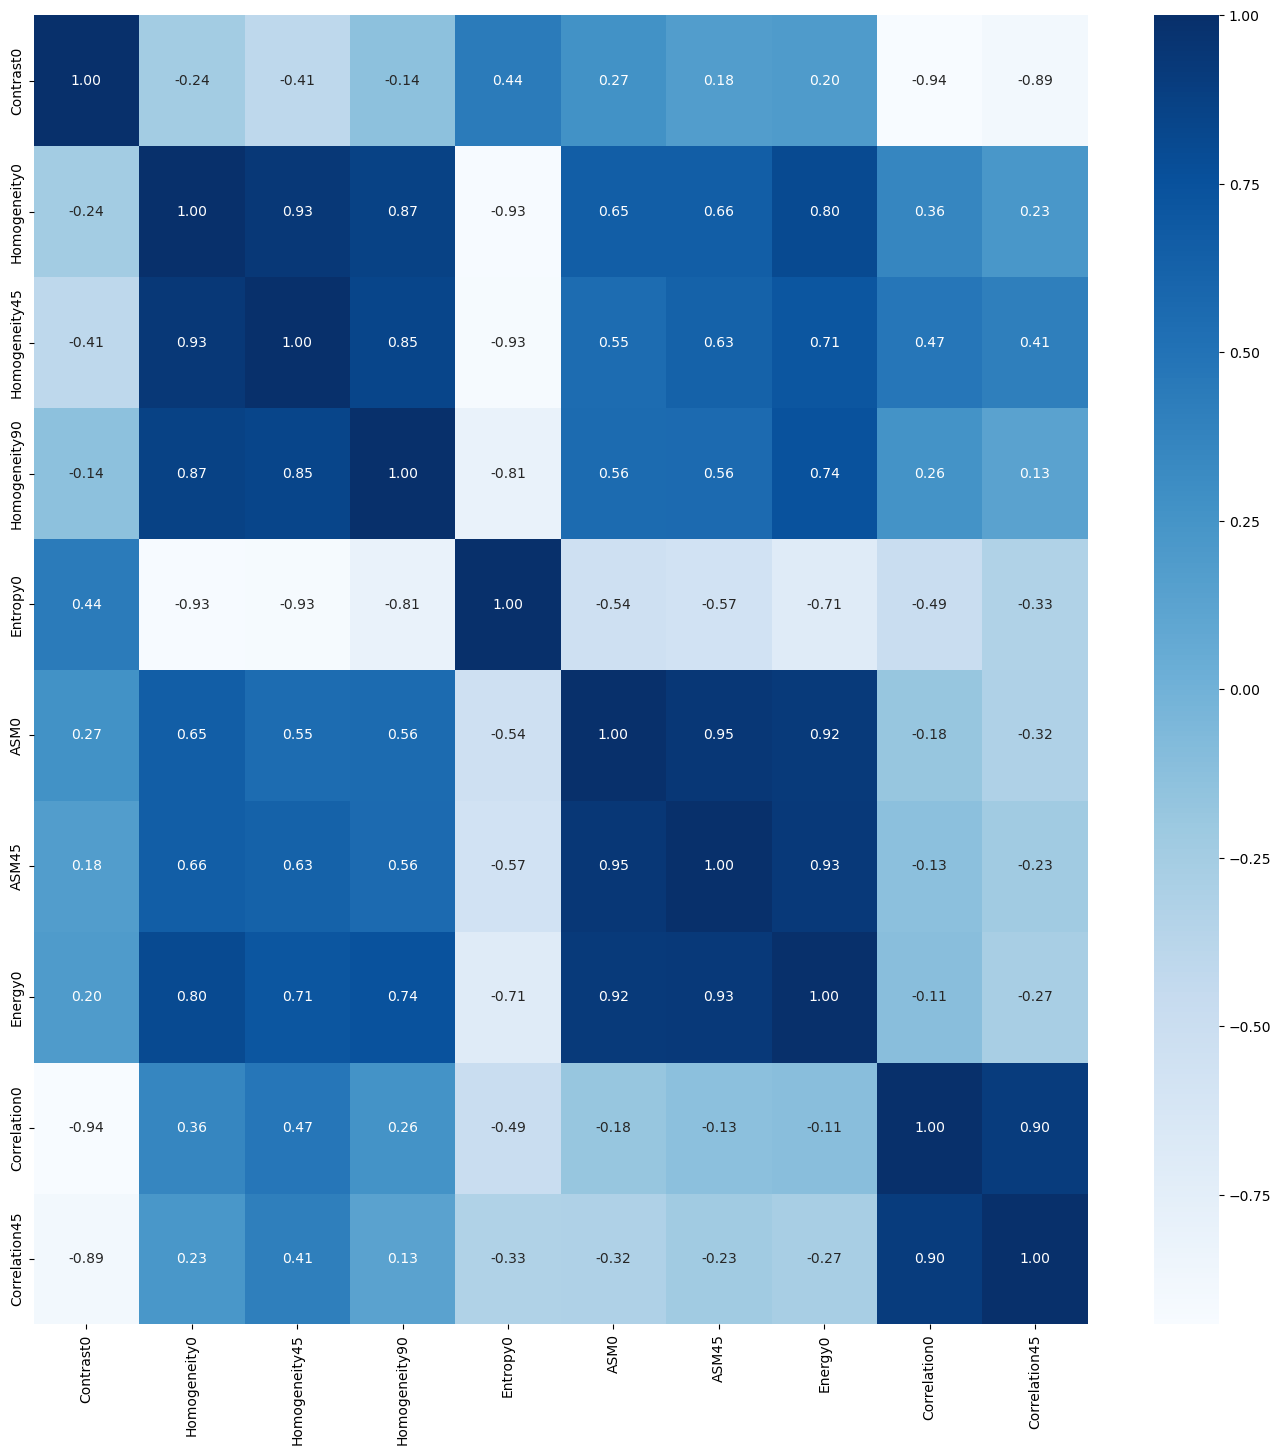

In [24]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [25]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 10)
(40, 10)


Kode di atas berfungsi untuk membagi dataset menjadi dua bagian utama, yaitu data latih dan data uji. Pemisahan ini dilakukan menggunakan fungsi `train_test_split` dari pustaka `sklearn.model_selection`. Nilai `test_size=0.2` menunjukkan bahwa 20% dari total data digunakan untuk pengujian, sedangkan sisanya, yaitu 80%, digunakan untuk pelatihan model. Pengaturan `random_state=42` ditambahkan agar hasil pembagian data bersifat tetap (reproducible) setiap kali kode dijalankan. Kemudian, `print(X_train.shape)` dan `print(X_test.shape)` digunakan untuk menampilkan ukuran masing-masing subset data, sehingga kita dapat memastikan proporsi pembagian data sudah sesuai. Pembagian ini penting agar model dapat belajar dari data latih dan diuji performanya secara objektif menggunakan data uji yang belum pernah dilihat sebelumnya.

## Feature Normalization

In [26]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode di atas merupakan proses normalisasi data menggunakan fungsi `mean()` dan `std()` pada variabel `X_train` dan `X_test`. Pada baris pertama, `X_test` dinormalisasi dengan mengurangi rata-rata `X_train.mean()` dan membagi dengan standar deviasi `X_train.std()`, agar skala data pengujian sama dengan data pelatihan. Baris kedua melakukan normalisasi yang sama pada `X_train`. Proses ini disebut z-score normalization, bertujuan membuat data memiliki rata-rata nol dan standar deviasi satu sehingga model dapat belajar dengan lebih baik tanpa terpengaruh perbedaan skala fitur.

# Modelling

## Define Modelling

In [27]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode di atas berisi fungsi `generateClassificationReport` yang menerima dua parameter, `y_true` dan `y_pred`, untuk mencetak laporan klasifikasi menggunakan `classification_report`, menampilkan matriks kebingungan lewat `confusion_matrix`, dan menghitung akurasi dengan `accuracy_score`. Fungsi ini berguna untuk evaluasi performa model klasifikasi. Selanjutnya, tiga objek classifier didefinisikan: `rf` adalah Random Forest dengan 5 pohon keputusan dan `random_state` 42 untuk reproduksibilitas, `svm` adalah Support Vector Machine dengan kernel RBF, dan `knn` adalah K-Nearest Neighbors dengan jumlah tetangga 5. Variabel-variabel ini akan digunakan untuk melatih dan menguji model klasifikasi pada dataset.

## Train Random Forest Classifier

Kode di bawah berfungsi untuk menjalankan proses pelatihan dan evaluasi model Random Forest yang telah didefinisikan sebelumnya sebagai `rf`. Pertama, model dilatih dengan data fitur `X_train` dan label `y_train` menggunakan fungsi `fit()`. Setelah itu, prediksi dilakukan pada data pelatihan (`X_train`) dengan `predict()`, kemudian hasil prediksi `y_pred` dievaluasi dengan memanggil fungsi `generateClassificationReport` menggunakan label asli `y_train` dan prediksi `y_pred`. Langkah ini menghasilkan laporan performa model pada data pelatihan. Selanjutnya, proses prediksi dan evaluasi yang sama juga diterapkan pada data pengujian (`X_test` dan `y_test`) untuk mengukur kemampuan generalisasi model terhadap data baru. Output menampilkan hasil evaluasi untuk training set dan testing set secara berurutan.

In [28]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       anger       0.99      0.95      0.97        79
       happy       0.95      0.99      0.97        81

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

[[75  4]
 [ 1 80]]
Accuracy: 0.96875

------Testing Set------
              precision    recall  f1-score   support

       anger       0.80      0.76      0.78        21
       happy       0.75      0.79      0.77        19

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40

[[16  5]
 [ 4 15]]
Accuracy: 0.775


## Tain SVM Classifier

Kode di bawah digunakan untuk melatih dan menguji model Support Vector Machine (SVM) yang sudah didefinisikan sebagai `svm`. Pertama, model SVM dilatih menggunakan data fitur `X_train` dan label `y_train` dengan metode `fit()`. Setelah pelatihan selesai, prediksi dilakukan pada data pelatihan `X_train` menggunakan `predict()`, dan hasil prediksi `y_pred` dievaluasi dengan fungsi `generateClassificationReport` menggunakan label asli `y_train` dan hasil prediksi `y_pred`. Evaluasi ini memberikan gambaran performa model pada data pelatihan. Selanjutnya, proses prediksi dan evaluasi yang sama dilakukan pada data pengujian `X_test` dan `y_test` untuk mengukur seberapa baik model SVM dapat menggeneralisasi terhadap data baru. Hasil evaluasi untuk training dan testing set ditampilkan secara terpisah.


In [29]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       anger       0.96      0.86      0.91        79
       happy       0.88      0.96      0.92        81

    accuracy                           0.91       160
   macro avg       0.92      0.91      0.91       160
weighted avg       0.92      0.91      0.91       160

[[68 11]
 [ 3 78]]
Accuracy: 0.9125

------Testing Set------
              precision    recall  f1-score   support

       anger       0.95      0.86      0.90        21
       happy       0.86      0.95      0.90        19

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

[[18  3]
 [ 1 18]]
Accuracy: 0.9


## Train KNN Classifier

Kode di bawah digunakan untuk melatih model K-Nearest Neighbors (KNN) dengan data pelatihan `X_train` dan label `y_train` melalui fungsi `fit()`. Setelah model terlatih, dilakukan prediksi pada data pelatihan menggunakan `knn.predict(X_train)` yang hasilnya disimpan dalam variabel `y_pred`. Selanjutnya, hasil prediksi tersebut dievaluasi dengan fungsi `generateClassificationReport` yang menerima label asli `y_train` dan prediksi `y_pred`, untuk menampilkan laporan klasifikasi, confusion matrix, serta nilai akurasi pada data pelatihan. Proses yang sama kemudian diterapkan pada data pengujian `X_test` dengan prediksi dan evaluasi hasil terhadap label `y_test`. Dengan cara ini, kode menampilkan performa model KNN baik pada data pelatihan maupun data pengujian.

In [30]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       anger       1.00      0.89      0.94        79
       happy       0.90      1.00      0.95        81

    accuracy                           0.94       160
   macro avg       0.95      0.94      0.94       160
weighted avg       0.95      0.94      0.94       160

[[70  9]
 [ 0 81]]
Accuracy: 0.94375

------Testing Set------
              precision    recall  f1-score   support

       anger       0.94      0.81      0.87        21
       happy       0.82      0.95      0.88        19

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40

[[17  4]
 [ 1 18]]
Accuracy: 0.875


## Evaluation With Confusion Matrix

Kode di bawah ini mendefinisikan fungsi `plot_confusion_matrix` yang bertugas menampilkan confusion matrix dari hasil prediksi model. Fungsi ini menerima tiga parameter: `y_true` sebagai label asli, `y_pred` sebagai hasil prediksi, dan `title` sebagai judul grafik. Di dalam fungsi, confusion matrix dihitung menggunakan `confusion_matrix`, lalu divisualisasikan dengan `ConfusionMatrixDisplay` menggunakan palet warna biru. Setelah itu, judul ditambahkan dan grafik ditampilkan menggunakan `plt.show()`.

Selanjutnya, fungsi ini dipanggil tiga kali untuk masing-masing model yang sudah dilatih, yaitu Random Forest (`rf`), Support Vector Machine (`svm`), dan K-Nearest Neighbors (`knn`). Setiap pemanggilan menggunakan data pengujian `X_test` dan label asli `y_test`, serta menampilkan confusion matrix sesuai modelnya dengan judul yang relevan. Dengan cara ini, pengguna dapat membandingkan performa visual ketiga model dalam hal klasifikasi.


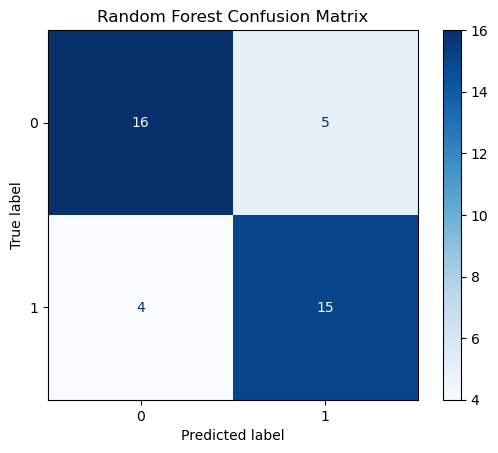

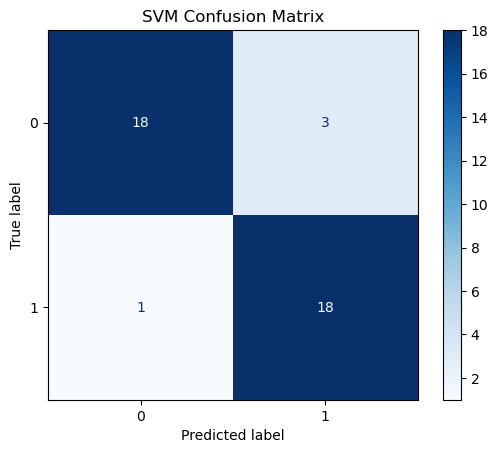

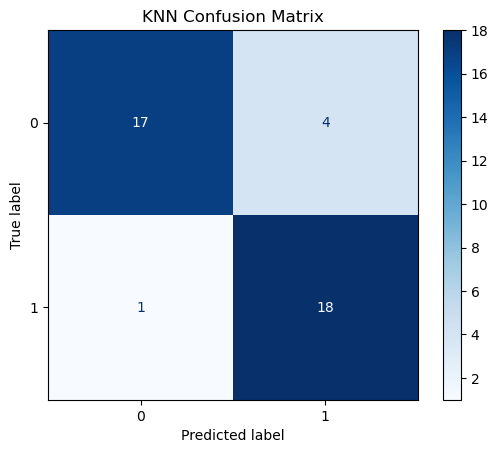

In [31]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")